<strong>Author:</strong> Oliver Pauer <br>
<strong>Date:</strong> 14.10.2023 <br>
<strong>Project:</strong> 3D-Shape generation from the Princeton University 3DShapeNets Dataset using a 3D-GAN.

# 3D Object generation based on the Princeton 3DShapeNets-Dataset using a 3D-GAN

A 3D-GAN works similarly to 2D-GAN (like DALL-E). <br>
The mayor difference is that it is using 3D-Convolutions in the Generator as well as the Discriminator (instead of Conv2D or Conv2DTranspose => Conv3D or Conv3DTranspose), also the data needs to be preprocessed differently than in a classical 2D-GAN, since we are working with voxels instead of poxels (voxel >= volumetric pixel, 3D-pixel). <br>

<strong>Structure of a 3D-GAN: </strong>

We have both a Discriminator and a Generator. The generator will upsample a random latent vector z into 3D using 3D-Convolutional Upsampling (Conv3DTranspose). The Discriminator will analyze the Generator Output in 3D with 3D-Convolution layers (Conv3D). If the Discriminator can't see a difference between the generator output and the original data from the dataset, the object is fully generated.

##<strong>Development:</strong><br>
### Step 1: Import libraries

In [ ]:
!pip install --upgrade trimesh

In [ ]:
!pip install open3d

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy
import open3d as o3d

from keras import layers, losses, utils, optimizers

## Step 2: Get the Princeton 3DShapeNet Dataset

In [ ]:
!wget http://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip

--2023-10-14 18:55:57--  http://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip
Resolving 3dshapenets.cs.princeton.edu (3dshapenets.cs.princeton.edu)... 128.112.136.67
Connecting to 3dshapenets.cs.princeton.edu (3dshapenets.cs.princeton.edu)|128.112.136.67|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip [following]
--2023-10-14 18:55:58--  https://3dshapenets.cs.princeton.edu/3DShapeNetsCode.zip
Connecting to 3dshapenets.cs.princeton.edu (3dshapenets.cs.princeton.edu)|128.112.136.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533450062 (509M) [application/zip]
Saving to: ‘3DShapeNetsCode.zip.1’

3DShapeNetsCode.zip 100%[===================>] 508.74M  38.7MB/s    in 14s     

2023-10-14 18:56:12 (36.3 MB/s) - ‘3DShapeNetsCode.zip.1’ saved [533450062/533450062]



In [ ]:
!unzip 3DShapeNetsCode.zip

Archive:  3DShapeNetsCode.zip
replace 3DShapeNets/kFunctions2.cu? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/kFunctions2.ptx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/run_finetuning.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/sample_test_extreme.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/rec_completion_test.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/sample_test_classification.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/rec_test.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/run_pretrain.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/kFunctions.cu? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/generative_40_class.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 3DShapeNets/NBV_onestep_

## Step 3: Displaying a single 3D-Object

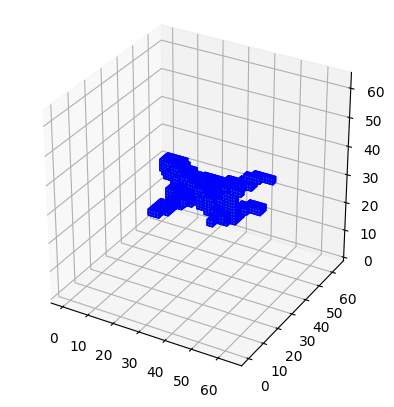

In [ ]:
voxels = scipy.io.loadmat("3DShapeNets/volumetric_data/airplane/30/test/e5bf09ef0e8de9e8a9de7e2f11b2d506_9.mat")["instance"]
voxels = np.pad(voxels, (1, 1), "constant", constant_values=(0, 0))
voxels = scipy.ndimage.zoom(voxels, (2, 2, 2), mode="constant", order=0)

def PlotVoxels(voxels):
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')

    ax.set_aspect('equal')
    ax.voxels(voxels, edgecolor="blue")

    plt.show()

"""
def PlotVoxels3D(voxels):
    voxel_grid = o3d.geometry.VoxelGrid()
    voxel_grid.voxels = o3d.utility.Vector3iVector(np.argwhere(voxels))

    o3d.visualization.draw_geometries([voxels])
"""

PlotVoxels(voxels)
# PlotVoxels3D(voxels)

## GAN
### Step 4: Generator
#### Step 4.1: Generator params

In [ ]:
Z_VECTOR_SIZE = 200
GENERATOR_FILTERS = [512, 256, 128, 64, 1]
GENERATOR_KERNEL_SIZES = [4, 4, 4, 4, 4]
GENERATOR_STRIDES = [1, 2, 2, 2, 2]
GENERATOR_INPUT_SHAPE = (1, 1, 1, Z_VECTOR_SIZE)
GENERATOR_ACTIVATIONS = ["relu", "relu", "relu", "relu", "sigmoid"]
GENERATOR_CONVOLUTION_BLOCKS = 5

#### Step 4.2: Construct the Generator Network

In [ ]:
def Generator3D():
    input_layer = layers.Input(shape=GENERATOR_INPUT_SHAPE)

    # first Upsampling
    x = layers.Conv3DTranspose(filters=GENERATOR_FILTERS[0], kernel_size=GENERATOR_KERNEL_SIZES[0], strides=GENERATOR_STRIDES[0])(input_layer)
    x = layers.BatchNormalization()(x, training=True)
    x = layers.Activation(activation="relu")(x)

    # next upsamplings
    for i in range(GENERATOR_CONVOLUTION_BLOCKS - 1):
        x = layers.Conv3DTranspose(filters=GENERATOR_FILTERS[i + 1], kernel_size=GENERATOR_KERNEL_SIZES[i + 1], strides=GENERATOR_STRIDES[i + 1], padding="same")(x)
        x = layers.BatchNormalization()(x, training=True)
        x = layers.Activation(activation=GENERATOR_ACTIVATIONS[i + 1])(x)

    generator = keras.Model(inputs=input_layer, outputs=x)

    return generator

### Step 5: Discriminator
#### Step 5.1: Discriminator params

In [ ]:
DISCRIMINATOR_INPUT_SHAPE = (64, 64, 64, 1)
DISCRIMINATOR_FILTERS = [64, 128, 256, 512, 1]
DISCRIMINATOR_KERNEL_SIZES = [4, 4, 4, 4, 4]
DISCRIMINATOR_STRIDES = [2, 2, 2, 2, 1]
DISCRIMINATOR_PADDINGS = ['same', 'same', 'same', 'same', 'valid']
DISCRIMINATOR_ALPHAS = [0.2, 0.2, 0.2, 0.2, 0.2]
DISCRIMINATOR_ACTIVATIONS = ['leaky_relu', 'leaky_relu', 'leaky_relu', 'leaky_relu', 'sigmoid']
DISCRIMINATOR_CONVOLUTIONAL_BLOCKS = 5

#### Step 5.2: Discriminator Network

In [ ]:
def Discriminator3D():
    input_layer = layers.Input(DISCRIMINATOR_INPUT_SHAPE)

    # first convolution
    x = layers.Conv3D(filters=DISCRIMINATOR_FILTERS[0], kernel_size=DISCRIMINATOR_KERNEL_SIZES[0], strides=DISCRIMINATOR_STRIDES[0], padding=DISCRIMINATOR_PADDINGS[0])(input_layer)
    x = layers.BatchNormalization()(x, training=True)
    x = layers.LeakyReLU(DISCRIMINATOR_ALPHAS[0])(x)

    # next convolutions
    for i in range(0, DISCRIMINATOR_CONVOLUTIONAL_BLOCKS - 1):
        x = layers.Conv3D(filters=DISCRIMINATOR_FILTERS[i + 1], kernel_size=DISCRIMINATOR_KERNEL_SIZES[i + 1], strides=DISCRIMINATOR_STRIDES[i + 1], padding=DISCRIMINATOR_PADDINGS[i + 1])(input_layer)
        x = layers.BatchNormalization()(x, training=True)

        if DISCRIMINATOR_ACTIVATIONS[i + 1] == "leaky_relu":
            x = layers.LeakyReLU(DISCRIMINATOR_ALPHAS[i + 1])(x)
        elif DISCRIMINATOR_ACTIVATIONS[i + 1] == "sigmoid":
            x = layers.Activation(activation="sigmoid")(x)

    discriminator = keras.Model(inputs=input_layer, outputs=x)

    return discriminator